# GLM regression demo

In this notebook we demonstate *revrand*'s GLM fitting draws from a latent GP passed though various likelihood functions. The aim is to see how well the GLM can model the noisy targets.


In [62]:
%matplotlib inline

import matplotlib.pyplot as pl
pl.style.use('ggplot')
import numpy as np
import logging
from scipy.stats import poisson, bernoulli, binom
from scipy.special import expit

from revrand import glm, likelihoods
from revrand.utils.datasets import gen_gausprocess_se
from revrand.btypes import Parameter, Positive
from revrand import basis_functions as bs
from revrand.mathfun.special import softplus
from revrand.optimize import AdaDelta, Adam

# Log output to the terminal attached to this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


## Dataset settings and latent function generation

In [63]:
N = 100  # Number of training points
Ns = 250  # Number of test points
lenscale_true = 1.2
noise_true = 0.1

Xtrain, ftrain, Xtest, ftest = \
            gen_gausprocess_se(N, Ns, lenscale=lenscale_true, noise=noise_true)
ytest = ftest + np.random.randn(Ns) * noise_true


## Algorithm Settings

In [64]:
nbases = 20  # Number of unique random bases to use for approximating a kernel
lenscale = 1  # Initial value for the lengthscale
noise = 1  # Initial value for target noise
reg = 1  # Initial weight prio

maxiter = 3000
batch_size = 10
use_sgd = True
sgd_upd = AdaDelta
updater_params = {}

# Setup random basis functions
len_ini = Parameter(lenscale, Positive())
basis = bs.RandomRBF(Xdim=1, nbases=nbases, lenscale_init=len_ini)


## Generic GLM calling code for learning, prediction and plotting


In [65]:
Xpl_t = Xtrain.flatten()
Xpl_s = Xtest.flatten()

def run_glm(ytrain, ytest, llhood, largs=(), slargs=()):

    updater = sgd_upd(**updater_params)
    
    # Learn
    params = glm.learn(Xtrain, ytrain, llhood, basis, likelihood_args=largs,
                       use_sgd=use_sgd, batch_size=batch_size, maxiter=maxiter,
                       updater=updater)

    # Get expected y and variance
    Ey, Vy, _, _ = glm.predict_moments(Xtest, llhood, basis, *params,
                                           likelihood_args=slargs)
    # p(y* <= 1)
    plt1, plt1n, plt1x = glm.predict_cdf(0, Xtest, llhood, basis, *params,
                                         likelihood_args=slargs)
    
    # Get the 95% interval
    y95n, y95x = glm.predict_interval(0.95, Xtest, llhood, basis, *params,
                                      likelihood_args=slargs)

    # Get the LP
    logp, _, _ = glm.predict_logpdf(ytest, Xtest, llhood, basis, *params,
                                    likelihood_args=slargs)
    
    print("Average log-likelihood: {}" .format(logp.mean()))

    # Plot Regressor
    pl.figure(figsize=(15, 10))
    pl.plot(Xpl_s, Ey, 'b-', label='GLM $\mathbb{E}[y*]$')

    pl.fill_between(Xpl_s, y95n, y95x, facecolor='none', edgecolor='b', label=None,
                    linestyle='--')

    pl.plot(Xpl_s, 1 - plt1, 'r-', label='NPV p(y >= 0).')
    pl.fill_between(Xpl_s, 1 - plt1n, 1 - plt1x, facecolor='r', edgecolor='none',
                    label=None, alpha=0.3)

    # Training/Truth
    pl.plot(Xpl_t, ytrain, 'k.', label='Training')
    pl.plot(Xpl_s, ftest, 'k-', label='Latent function')

    pl.legend()
    pl.grid(True)
    pl.title('GLM prediction')
    pl.ylabel('y')
    pl.xlabel('x')

    # Plot Regressor posterior
    m, C = params[0:2]
    pl.figure(figsize=(15, 10))
    K = m.shape[1]
    cols = pl.cm.jet(np.linspace(0, 1, K))
    for mk, Ck, c in zip(m.T, C.T, cols):
        pl.plot(range(len(mk)), mk, color=c)
        pl.fill_between(range(len(mk)), mk - 2 * np.sqrt(Ck), mk + 2 * np.sqrt(Ck),
                        alpha=0.1, edgecolor='none', facecolor=c, label=None)

    pl.grid(True)
    pl.title('GLM Weight Posterior')
    pl.ylabel('w')
    pl.xlabel('basis index')

    pl.show()


## Gaussian likelihood

Average log-likelihood: 0.20381342059519858


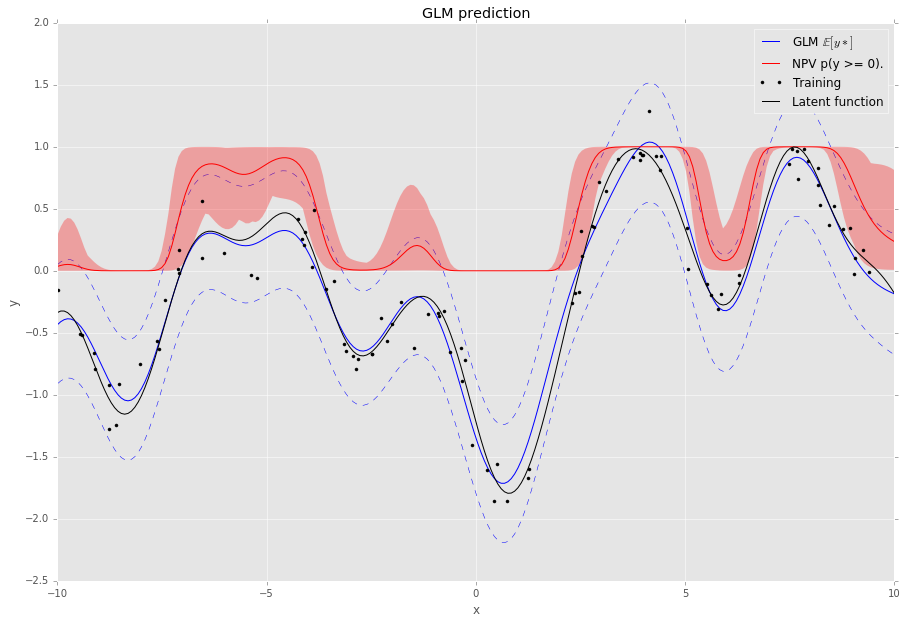

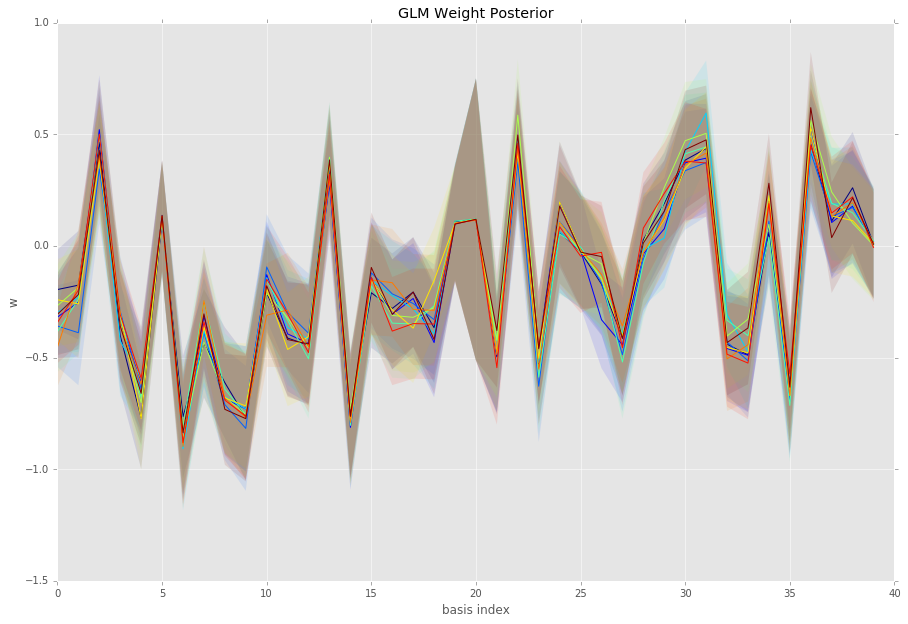

In [66]:
ytrain_gaus = ftrain + np.random.randn(N) * noise_true
ytest_gaus = ftest + np.random.randn(Ns) * noise_true
gauss = likelihoods.Gaussian(var_init=Parameter(noise**2, Positive()))

run_glm(ytrain_gaus, ytest_gaus, gauss)


## Poisson Likelihood

Average log-likelihood: -1.204963626193524


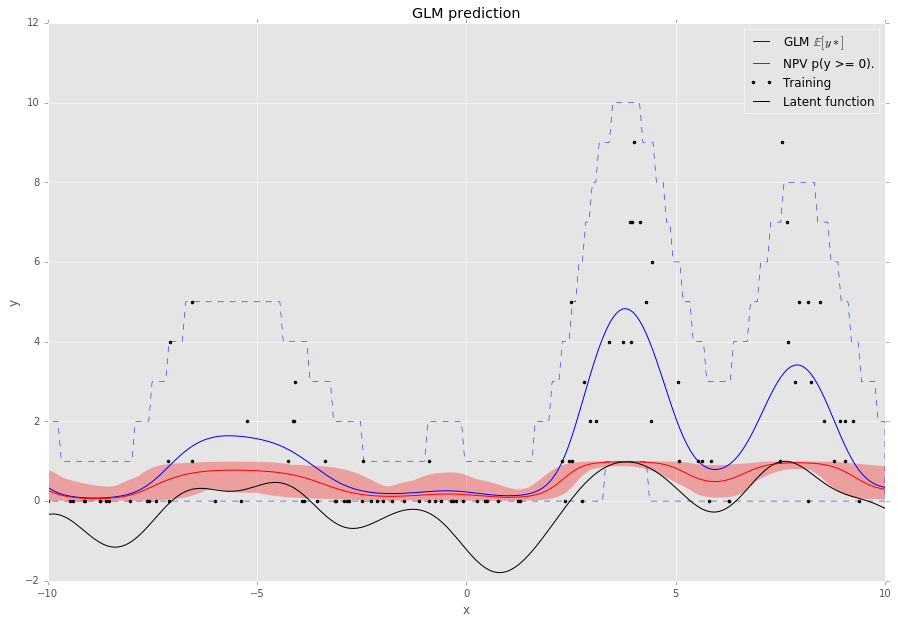

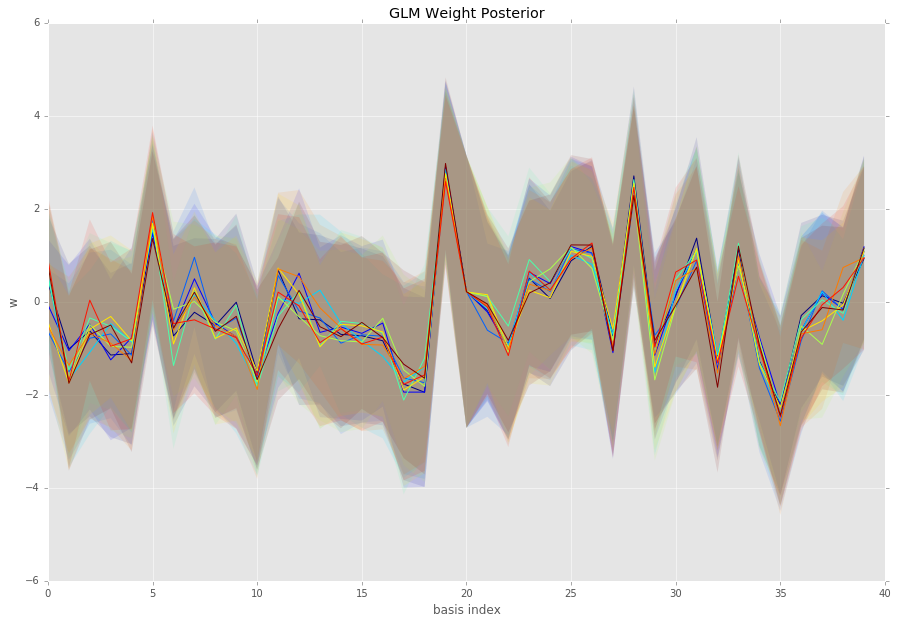

In [67]:
ytrain_pois = poisson.rvs(softplus(5 * ftrain))
ytest_pois = poisson.rvs(softplus(5 * ftest))
pois = likelihoods.Poisson(tranfcn='softplus')

run_glm(ytrain_pois, ytest_pois, pois)


## Bernoulli Likelihood

Average log-likelihood: -0.3177186045020864


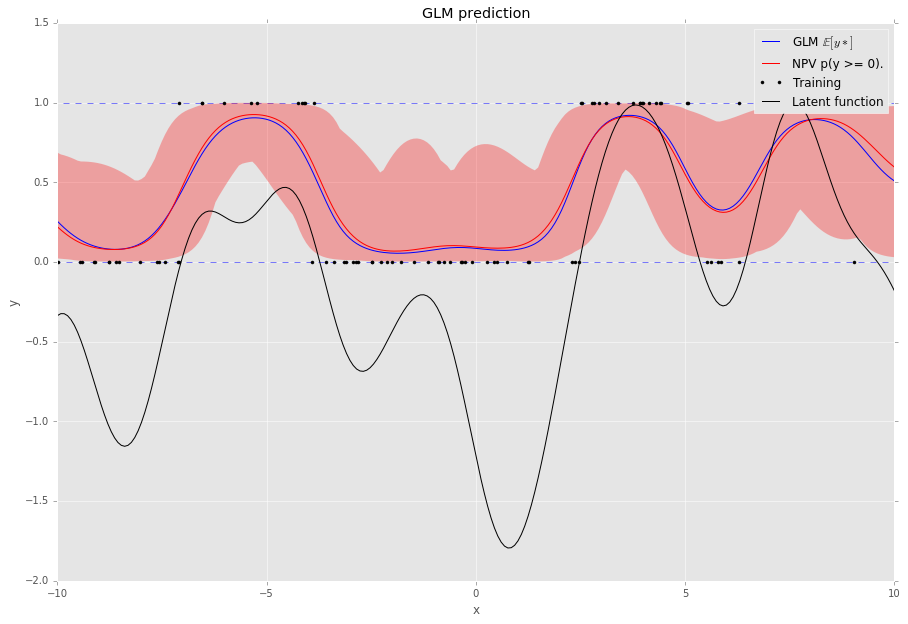

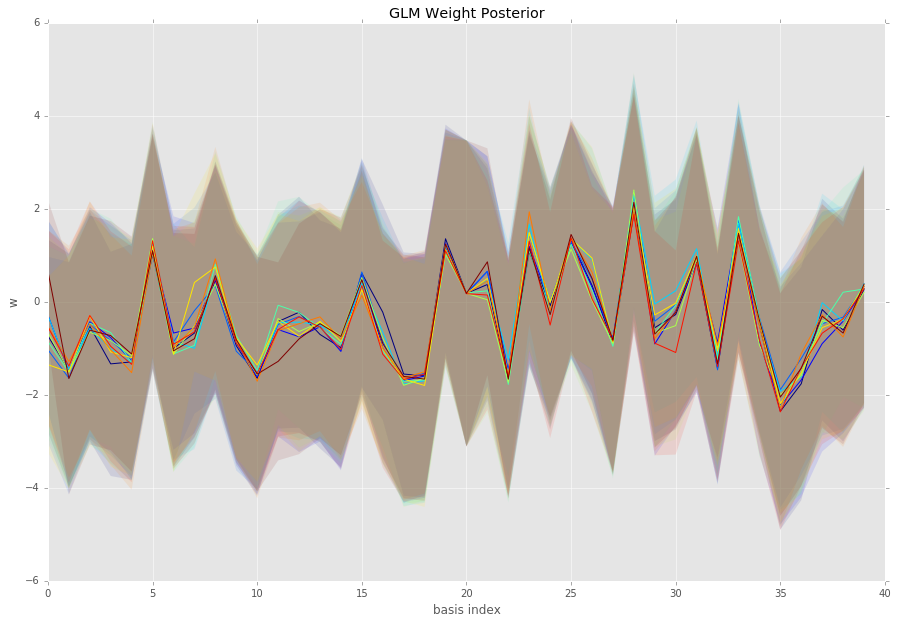

In [68]:
ytrain_bern = bernoulli.rvs(expit(20 * ftrain))
ytest_bern = bernoulli.rvs(expit(20 * ftest))
bern = likelihoods.Bernoulli()

run_glm(ytrain_bern, ytest_bern, bern)


## Binomial Likelihood

Average log-likelihood: -1.5377411482913832


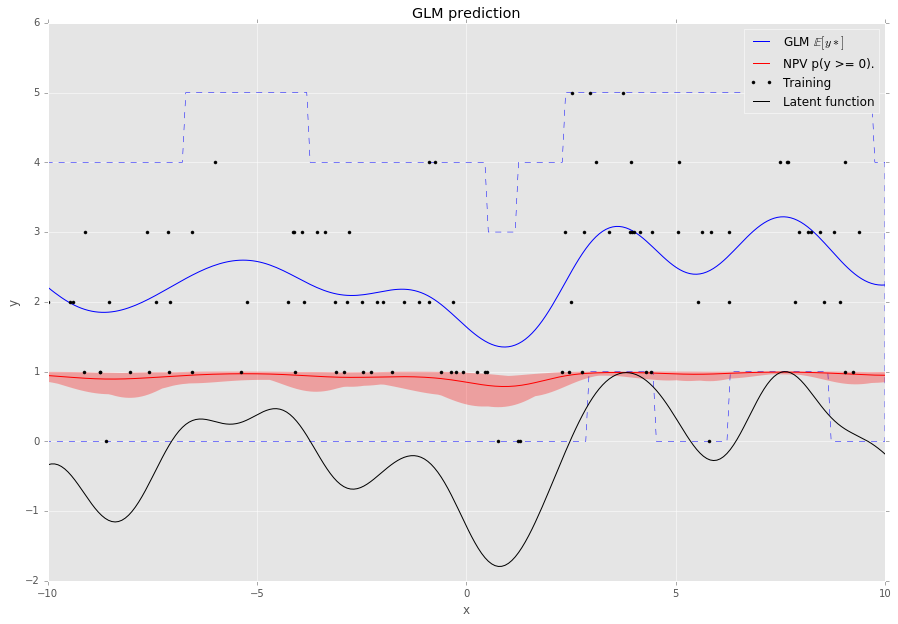

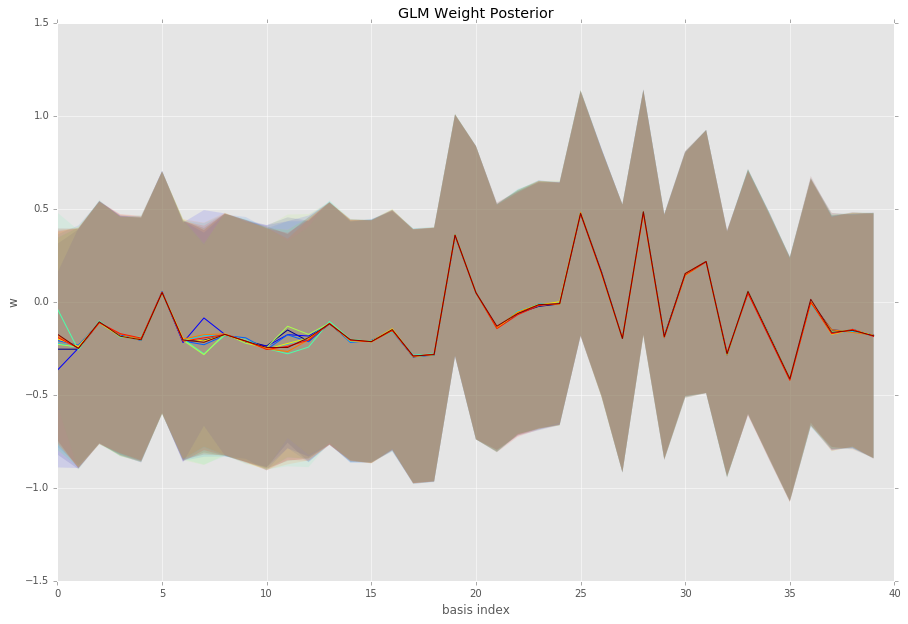

In [75]:
n = 5
ytrain_bin = binom.rvs(n=n * np.ones(N, dtype=int), p=expit(ftrain))
ytest_bin = binom.rvs(n=n * np.ones(Ns, dtype=int), p=expit(ftest))
largs = (n * np.ones(N, dtype=int),)
slargs = (n * np.ones(Ns, dtype=int),)
binom = likelihoods.Binomial()

run_glm(ytrain_bin, ytest_bin, binom, largs, slargs)
